In [10]:
import xgboost as xgb 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
import optuna
import pickle

from tqdm import tqdm
from utils.common import day_aware_shift
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, make_scorer, matthews_corrcoef, \
    classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier, Pool

In [33]:
def target_pipeline(df, feature='z_close_30m', shift=5, threshold=0.5):
    def get_trend(x):
        if x > threshold:
            return 'up'
        elif x < -threshold:
            return 'down'
        else:
            return 'neutral'
    df = df.copy()
    df['target'] = df[feature].apply(get_trend)
    if 'datetime' not in df.columns:
        df['datetime'] = df.index
    df = day_aware_shift(df, 'target', -shift)
    df = df.drop(labels='datetime', axis=1)

    return df

def target_pipeline2(df, feature=None, shift=5, threshold=0.5):
    def get_trend(x):
        if x >= threshold:
            return 'up'
        elif x < -threshold:
            return 'down'
        else:
            return 'neutral'

    df = df.copy()
    if 'datetime' not in df.columns:
        df['datetime'] = df.index
    df = day_aware_shift(df, f'sma_close_{feature}', shift, '_tmp')
    df = day_aware_shift(df, f'std_close_{feature}', shift, '_tmp2')
    df['target'] = (df['close'] - df['_tmp']) / df['_tmp2']
    df['target'] = df['target'].apply(get_trend)
    df = day_aware_shift(df, 'target', -shift)
    df = df.drop(['_tmp', '_tmp2', 'datetime'], axis=1)

    return df

def target_pipeline3(df, feature=None, shift=5, threshold=None):
    if 'datetime' not in df.columns:
        df['datetime'] = df.index
    
    df_result = []
    for day, df_day in df.groupby(pd.Grouper(key='datetime', freq='D')):
        if df_day.shape[0] == 0:
            continue
        df_day = df_day.copy()
        df_day['target'] = df_day['close'].pct_change(feature)
        df_day['target'] = (df_day['target'] > 0).astype(int)

    df_result.append(df_day)
    df_result = pd.concat(df_result)
    df_result = day_aware_shift(df_result, 'target', shift)
    df_result = df_result.drop(labels='datetime', axis=1)

    return df_result

In [3]:
class TimeSeriesCV:
    def __init__(self, train_length=24, val_length=8, interval=1):
        # train on ~6 months, predict 2
        # ~6 months = 4 * 6 = 24 days
        # ~2 months = 4 * 2 = 8 days

        self.train_length = train_length
        self.val_length = val_length
        self.interval = interval

    def split(self, X, y=None, groups=None):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            unique_dates = X.index.to_period('D').unique()
        days = sorted(unique_dates, reverse=False)
        n_days = len(days)

        period_length = n_days - self.val_length - self.train_length + 1

        for idx in range(0, period_length, self.interval):
            train_days = days[idx:(idx+self.train_length)]
            val_days = days[(idx+self.train_length):(idx+self.train_length+self.val_length)]
            # train_days = days[:(idx+self.train_length)]

            with warnings.catch_warnings():
                warnings.simplefilter('ignore', UserWarning)
                train_idx = X[X.index.to_period('D').isin(train_days)].index
                val_idx = X[X.index.to_period('D').isin(val_days)].index

            yield train_idx.to_numpy(), val_idx.to_numpy()

In [6]:
with pd.HDFStore('./large_files/data2.h5', mode='r') as store:
    df = store.get('data/features_20240215')
df.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2568270 entries, 525 to 116265
Data columns (total 259 columns):
 #    Column                          Dtype                           
---   ------                          -----                           
 0    date                            object                          
 1    time                            object                          
 2    open                            float64                         
 3    high                            float64                         
 4    low                             float64                         
 5    close                           float64                         
 6    volume                          int64                           
 7    datetime                        datetime64[ns, America/New_York]
 8    day                             object                          
 9    month                           int64                           
 10   bb_30_high                 

In [7]:
to_drop = [c for c in df.columns if 'sma' in c] + [c for c in df.columns if 'std' in c] + \
    ['date', 'time', 'open', 'high', 'low', 'close', 'volume', 'day', 'dollar_vol']

cat_cols = ['month', 'rsi_5_signal', 'rsi_10_signal', 'rsi_15_signal', 'rsi_30_signal', 'rsi_60_signal']

drop_later = [c for c in df.columns if 'z_close' in c] + [c for c in df.columns if 'pct_close' in c]

# convert month to categorical, rsi signal is already categorical
df['month'] = pd.Categorical(df['month'])

In [8]:
df2 = df.set_index('datetime', drop=True)
# df2 = df2[df2.index.dayofweek == 2]
# df2 = df2.drop(to_drop, axis=1)

df2.info(show_counts=True, verbose=3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2568270 entries, 2007-04-02 07:00:00-04:00 to 2024-02-09 16:59:00-05:00
Data columns (total 258 columns):
 #    Column                          Non-Null Count    Dtype   
---   ------                          --------------    -----   
 0    date                            2568270 non-null  object  
 1    time                            2568270 non-null  object  
 2    open                            2568270 non-null  float64 
 3    high                            2568270 non-null  float64 
 4    low                             2568270 non-null  float64 
 5    close                           2568270 non-null  float64 
 6    volume                          2568270 non-null  int64   
 7    day                             2568270 non-null  object  
 8    month                           2568270 non-null  category
 9    bb_30_high                      2442062 non-null  float64 
 10   bb_30_low                       2442062 non-null  float

In [9]:
df_train = df2.loc[df2.index.year.isin([2021, 2022])]
cv = TimeSeriesCV(120, 40, interval=40)
for i, (train_idx, test_idx) in enumerate(cv.split(X=df_train)):
    train_dates = df_train.loc[train_idx].index.unique()
    test_dates = df_train.loc[test_idx].index.unique()
    print(f'Train: {train_dates.min()} to {train_dates.max()} Val: {test_dates.min()} to {test_dates.max()}')

Train: 2021-01-04 07:00:00-05:00 to 2021-06-21 16:59:00-04:00 Val: 2021-06-22 07:00:00-04:00 to 2021-08-16 16:59:00-04:00
Train: 2021-03-01 07:00:00-05:00 to 2021-08-16 16:59:00-04:00 Val: 2021-08-17 07:00:00-04:00 to 2021-10-11 16:59:00-04:00
Train: 2021-04-27 07:00:00-04:00 to 2021-10-11 16:59:00-04:00 Val: 2021-10-12 07:00:00-04:00 to 2021-12-06 16:59:00-05:00
Train: 2021-06-22 07:00:00-04:00 to 2021-12-06 16:59:00-05:00 Val: 2021-12-07 07:00:00-05:00 to 2022-02-01 16:59:00-05:00
Train: 2021-08-17 07:00:00-04:00 to 2022-02-01 16:59:00-05:00 Val: 2022-02-02 07:00:00-05:00 to 2022-03-29 16:59:00-04:00
Train: 2021-10-12 07:00:00-04:00 to 2022-03-29 16:59:00-04:00 Val: 2022-03-30 07:00:00-04:00 to 2022-05-25 16:59:00-04:00
Train: 2021-12-07 07:00:00-05:00 to 2022-05-25 16:59:00-04:00 Val: 2022-05-26 07:00:00-04:00 to 2022-07-20 16:58:00-04:00
Train: 2022-02-02 07:00:00-05:00 to 2022-07-20 16:58:00-04:00 Val: 2022-07-21 07:00:00-04:00 to 2022-09-14 16:59:00-04:00
Train: 2022-03-30 07:00:

- Identify how long ahead should we predict
- Threshold of signal
- What target to use

In [37]:
df_train = df2.loc[df2.index.year.isin([2021, 2022])]
cv = TimeSeriesCV(120, 40, 40)

# lookaheads = [5, 15, 30, 60]
# thresholds = [0.5, 1.0, 1.5]
# targets = ['z_close_30m', 'z_close_15m', 'z_close_5m']

# train params
# lookahead, threshold, target
# train_params = [
#     (5, 0.0002, 'pct_close_15m'),
#     (5, 0.0003, 'pct_close_15m'),
#     (5, 0.0005, 'pct_close_15m'),

#     (10, 0.0002, 'pct_close_15m'),
#     (10, 0.0003, 'pct_close_15m'),
#     (10, 0.0005, 'pct_close_15m'),
# ]

# base_params = {
#     'objective': 'binary:logloss',
#     'random_state': 42,
#     'learning_rate': 0.05,
#     'nthread': -1,
#     'max_depth': 5,
#     'early_stopping_rounds': 10,
#     'tree_method': 'hist',
#     'enable_categorical': True,
#     'num_class': 3,
#     'device': 'cuda'
# }

train_params = [
    (5, None, 5),
    (10, None, 10),
    (15, None, 15),

    # (10, 1.0, 'z_close_5m'),
    # (10, 1.0, 'z_close_10m'),
    # (10, 1.0, 'z_close_15m'),
]

# le = LabelEncoder()
# le.fit(target_pipeline(df_train, 'z_close_5m')['target'])

df_fold = []
df_pred = []
df_importance = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X=df_train)):
    train_dates = df_train.loc[train_idx].index.unique()
    val_dates = df_train.loc[val_idx].index.unique()

    train_set = df_train.loc[train_dates]
    train_set = train_set[train_set.index.day == 2]
    val_set = df_train.loc[val_dates.min():val_dates.max()]

    df_fold_result = []
    for lookahead, threshold, target in train_params:
        train_set2 = train_set.copy()
        val_set2 = val_set.copy()

        train_set2 = target_pipeline3(train_set2, target, lookahead, threshold)
        val_set2 = target_pipeline3(val_set2, target, lookahead, threshold)

        train_set2 = train_set2.drop(to_drop, axis=1)
        val_set2 = val_set2.drop(to_drop, axis=1)

        train_set2 = train_set2[(train_set2.index.hour >= 9) & (train_set2.index.hour < 16)]
        val_set2 = val_set2[(val_set2.index.hour >= 9) & (val_set2.index.hour < 16)]

        train_set2 = train_set2.dropna(axis=0)
        val_set2 = val_set2.dropna(axis=0)

        Xtr, ytr = train_set2.drop('target', axis=1), train_set2['target']
        Xvl, yvl = val_set2.drop('target', axis=1), val_set2['target']

        # ytr = le.transform(ytr)
        # yvl = le.transform(yvl)

        # catboost
        train_pool = Pool(Xtr, label=ytr, cat_features=cat_cols)
        val_pool = Pool(Xvl, label=yvl, cat_features=cat_cols)
        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.02,
            depth=5,
            min_data_in_leaf=10,
            # loss_function='MultiClass',
            loss_function="Logloss",
            task_type='GPU',
            eval_metric='MCC',
            early_stopping_rounds=100,
            # classes_count=3
        )
        model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=False
        )

        # model = xgb.XGBClassifier(**base_params)
        # model.fit(
        #     Xtr, 
        #     ytr, 
        #     eval_set=[(Xtr, ytr), (Xvl, yvl)], 
        #     verbose=False
        # )


        # ytr_pred = model.predict(Xtr)
        # y_pred = model.predict(Xvl)

        ytr_pred_prob = model.predict_proba(Xtr)
        y_pred_proba = model.predict_proba(Xvl)

        calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        calibrated_model.fit(Xtr, ytr)
        ytr_pred = calibrated_model.predict(Xtr)
        y_pred = calibrated_model.predict(Xvl)

        val_set3 = val_set2.copy()
        pred_result = pd.DataFrame(index=val_set3.index)
        pred_result['fold'] = fold
        pred_result['lookahead'] = lookahead
        pred_result['threshold'] = threshold
        pred_result['target'] = target
        pred_result['ground_truth'] = val_set3['target']
        pred_result['pred'] = y_pred
        pred_result[['pred0', 'pred1']] = y_pred_proba
        df_pred.append(pred_result)
        
        # fi = pd.Series(model.feature_importances_, index=model.feature_names_)
        fi = pd.Series(calibrated_model.estimator.feature_importances_, index=calibrated_model.estimator.feature_names_)
        fi['fold'] = fold
        fi['lookahead'] = lookahead
        fi['threshold'] = threshold
        fi['target'] = target
        
        df_importance.append(fi.to_dict())

        df_fold_result.append({
            'fold': fold,
            'lookahead': lookahead,
            'threshold': threshold,
            'target': target,
            'accuracy': accuracy_score(yvl, y_pred),
            'precision': precision_score(yvl, y_pred, average="weighted", zero_division=0.),
            'recall': recall_score(yvl, y_pred, average="weighted", zero_division=0.),
            'f1': f1_score(yvl, y_pred, average="weighted"),
            'mcc': matthews_corrcoef(yvl, y_pred),
            'mcc_train': matthews_corrcoef(ytr, ytr_pred)
        })

        print(f'{fold}  Lookahead: {lookahead}  Threshold: {threshold}  Target: {target}  MCC: {matthews_corrcoef(yvl, y_pred):.2f}')

    df_fold_result = pd.DataFrame(df_fold_result).sort_values(['lookahead', 'threshold'])
    df_fold.append(df_fold_result)

0  Lookahead: 5  Threshold: None  Target: 5  MCC: 0.54
0  Lookahead: 10  Threshold: None  Target: 10  MCC: 0.53
0  Lookahead: 15  Threshold: None  Target: 15  MCC: 0.65
1  Lookahead: 5  Threshold: None  Target: 5  MCC: 0.38
1  Lookahead: 10  Threshold: None  Target: 10  MCC: 0.58
1  Lookahead: 15  Threshold: None  Target: 15  MCC: 0.56
2  Lookahead: 5  Threshold: None  Target: 5  MCC: 0.51
2  Lookahead: 10  Threshold: None  Target: 10  MCC: 0.66
2  Lookahead: 15  Threshold: None  Target: 15  MCC: 0.33
3  Lookahead: 5  Threshold: None  Target: 5  MCC: 0.47
3  Lookahead: 10  Threshold: None  Target: 10  MCC: 0.63
3  Lookahead: 15  Threshold: None  Target: 15  MCC: 0.39
4  Lookahead: 5  Threshold: None  Target: 5  MCC: 0.49
4  Lookahead: 10  Threshold: None  Target: 10  MCC: 0.66
4  Lookahead: 15  Threshold: None  Target: 15  MCC: 0.55
5  Lookahead: 5  Threshold: None  Target: 5  MCC: 0.45
5  Lookahead: 10  Threshold: None  Target: 10  MCC: 0.59
5  Lookahead: 15  Threshold: None  Target: 

In [38]:
df_pred = pd.concat(df_pred)
df_importance = pd.DataFrame(df_importance)
df_fold = pd.concat(df_fold, ignore_index=True)

In [24]:
with pd.HDFStore('./large_files/training2.h5') as store:
    # store.put('cat_cv/20240211/prediction', df_pred, format='table')
    # store.put('cat_cv/20240211/feature_importance', df_importance, format='table')
    # store.put('cat_cv/20240211/fold', df_fold, format='table')

    store.put('cat/prediction_20240216', df_pred, format='table')
    store.put('cat/feature_importance_20240216', df_importance, format='table')
    store.put('cat/fold_20240216', df_fold, format='table')

In [25]:
with pd.HDFStore('./large_files/training2.h5') as store:
    print(list(store.keys()))

['/cat/feature_importance_20240215', '/cat/feature_importance_20240215_cal', '/cat/feature_importance_20240216', '/cat/fold_20240215', '/cat/fold_20240215_cal', '/cat/fold_20240216', '/cat/prediction_20240215', '/cat/prediction_20240215_cal', '/cat/prediction_20240216']


In [85]:
del df_pred
del df_importance
del df_fold

In [14]:
with pd.HDFStore('./large_files/training2.h5', mode='r') as store:
    # df_pred = store.get('cat_cv/20240211/prediction')
    # df_importance = store.get('cat_cv/20240211/feature_importance')
    # df_fold = store.get('cat_cv/20240211/fold')

    df_pred = store.get('cat/prediction_20240215')
    df_importance = store.get('cat/feature_importance_20240215')
    df_fold = store.get('cat/fold_20240215')

In [47]:
df_fold['fold'] = df_fold['fold'].astype(str)
df_fold.groupby(['lookahead', 'target']).mean(numeric_only=True).reset_index()

,lookahead,target,accuracy,precision,recall,f1,mcc,mcc_train
0,5,5,0.741221,0.743040,0.741221,0.740520,0.481093,0.667855
1,10,10,0.802897,0.807602,0.802897,0.800635,0.600762,0.769965
2,15,15,0.729462,0.741671,0.729462,0.721193,0.455162,0.789907


In [42]:
df_fold.groupby(['lookahead', 'target']).mean(numeric_only=True).reset_index().sort_values('mcc', ascending=False).head(10)

,lookahead,target,accuracy,precision,recall,f1,mcc,mcc_train
1,10,10,0.802897,0.807602,0.802897,0.800635,0.600762,0.769965
0,5,5,0.741221,0.743040,0.741221,0.740520,0.481093,0.667855
2,15,15,0.729462,0.741671,0.729462,0.721193,0.455162,0.789907


In [28]:
df_importance['fold'] = df_importance['fold'].astype(str)
df_importance.groupby(['lookahead', 'threshold', 'target']).mean(numeric_only=True).reset_index()

,lookahead,threshold,target,month,bb_30_high,bb_30_low,bb_15_high,bb_15_low,bb_10_high,bb_10_low,...,lag5m_dst_dollar_vol_high_60m,lag5m_dst_dollar_vol_low_60m,lag10m_dst_dollar_vol_high_60m,lag10m_dst_dollar_vol_low_60m,lag15m_dst_dollar_vol_high_60m,lag15m_dst_dollar_vol_low_60m,lag30m_dst_dollar_vol_high_60m,lag30m_dst_dollar_vol_low_60m,lag60m_dst_dollar_vol_high_60m,lag60m_dst_dollar_vol_low_60m
0,5.0,1.0,z_close_10m,0.0,0.000000,0.000000,2.211893,0.000000,1.417767,0.220063,...,0.184555,0.188742,0.000000,0.207154,0.119287,0.150651,0.000000,0.000000,0.560474,0.983435
1,5.0,1.0,z_close_3m,0.0,0.000000,1.147228,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.206063,1.794604,0.000000,1.125479,0.614559,1.378056,1.257963,0.000000,0.000000
2,5.0,1.0,z_close_5m,0.0,0.139211,0.000000,0.259249,0.000000,0.300417,0.398752,...,2.399191,0.601827,0.000000,0.849475,3.237691,1.470365,0.241991,1.116840,0.701486,0.388900
3,10.0,1.0,z_close_10m,0.0,0.401724,0.180175,0.302697,0.420451,0.150453,0.239822,...,0.157159,0.105961,0.301796,1.371395,0.306356,0.412523,0.448205,1.667220,0.815132,0.744385
4,10.0,1.0,z_close_15m,0.0,0.405668,0.195396,0.010132,0.657963,0.071046,3.406974,...,0.124040,0.110615,0.330326,0.069368,0.139472,0.367721,0.258599,1.447305,0.118473,0.302018
5,10.0,1.0,z_close_5m,0.0,0.000000,0.000000,0.062846,0.000000,0.503740,0.000000,...,0.000000,0.322920,1.545122,0.485448,0.193562,0.000000,3.211213,0.000000,2.432640,0.999485


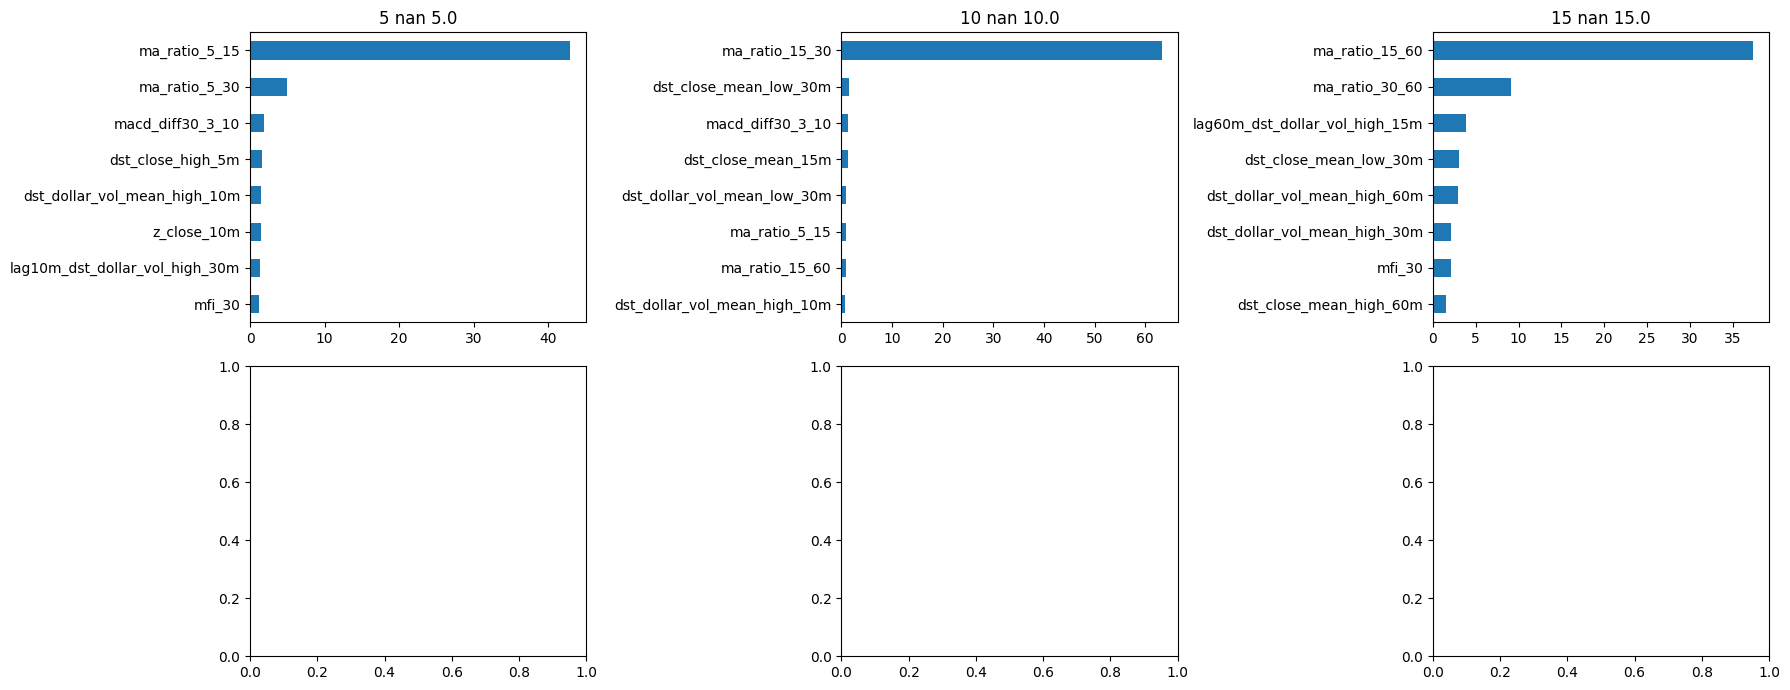

In [53]:
plot_n_cols = 3

fig, axs = plt.subplots(2, plot_n_cols, figsize=(18, 7))

for idx, row in df_importance.groupby(['lookahead', 'target']).mean(numeric_only=True).reset_index().iterrows():
    lookahead = row['lookahead']
    threshold = row['threshold']
    target = row['target']

    row = row.drop(['lookahead', 'threshold', 'target', 'fold']).sort_values(ascending=True)[-8:]
    ax = axs[idx//plot_n_cols, idx%plot_n_cols]
    ax.set_title(f'{int(lookahead)} {threshold} {target}')
    row.plot.barh(ax=ax)

plt.tight_layout()
plt.show()

In [46]:
df_dist_result = []

train_params = []
for idx, row in df_fold.groupby(['lookahead', 'target']).mean(numeric_only=True).reset_index().iterrows():
    train_params.append((row['lookahead'], row['target']))

# le = pickle.load(open('./large_files/up_down_neutral.pkl', 'rb'))

for lookahead, target in train_params:
    df_target_dist = df_pred[
        (df_pred['lookahead'] == lookahead) &
        # (df_pred['threshold'] == threshold) &
        (df_pred['target'] == target)
    ]
    dist = df_target_dist['ground_truth'].value_counts() / df_target_dist['ground_truth'].value_counts().sum()
    dist_pred = df_target_dist['pred'].value_counts() / df_target_dist['pred'].value_counts().sum()
    # dist_pred.index = le.inverse_transform(dist_pred.index)
    dist_pred = dist_pred.add_prefix('pred_')
    
    dist = pd.concat([dist, dist_pred])
    dist['lookahead'] = lookahead
    dist['threshold'] = threshold
    dist['target'] = target
    df_dist_result.append(dist)

pd.DataFrame(df_dist_result)

,0.0,1.0,pred_0.0,pred_1.0,lookahead,threshold,target
0,0.509851,0.490149,0.532215,0.467785,5.0,NaN,5.0
1,0.523429,0.476571,0.523962,0.476038,10.0,NaN,10.0
2,0.518104,0.481896,0.575612,0.424388,15.0,NaN,15.0


# Looking at 2021 / 2022 predictions

In [105]:
le = LabelEncoder().fit(df_pred['ground_truth'])
df_pred['ground_truth'] = le.transform(df_pred['ground_truth'])
df_pred.head()

,fold,lookahead,threshold,target,ground_truth,pred,pred0,pred1,pred2
datetime,,,,,,,,,
2021-06-22 09:00:00-04:00,0,10,1.0,5m,1,0,0.380325,0.302426,0.317249
2021-06-22 09:01:00-04:00,0,10,1.0,5m,1,0,0.367111,0.316788,0.316101
2021-06-22 09:02:00-04:00,0,10,1.0,5m,2,0,0.380056,0.320428,0.299516
2021-06-22 09:03:00-04:00,0,10,1.0,5m,2,0,0.375671,0.324773,0.299557
2021-06-22 09:04:00-04:00,0,10,1.0,5m,2,0,0.349144,0.317859,0.332997


In [106]:
le.classes_

array(['down', 'neutral', 'up'], dtype=object)

In [107]:
periods = {
    0: ('09:00:00', '09:59:59'),
    1: ('10:00:00', '11:59:59'),
    2: ('12:00:00', '13:59:59'),
    3: ('14:00:00', '15:59:59')
}

df_result_period = []
for day, df_day in df_pred.groupby(pd.Grouper(level='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    
    for fold in df_day['fold'].unique():
        df_day2 = df_day[(df_day['fold'] == fold) & (df_day['target'] == '10m') & (df_day['lookahead'] == 10) & (df_day['threshold'] == 1.0)]
        # df_day2['pred'] = np.argmax(df_day2[['pred0', 'pred1', 'pred2']].to_numpy(), axis=1)
        
        # divide day into 4 segments
        # 0900 0959, 1000 1159, 1200 1359, 1400 1559
        for period_id, period in periods.items():
            df_period = df_day2.between_time(period[0], period[1])
            if df_day2.shape[0] == 0:
                continue
            result = {
                'day': df_day2.index[0].date(),
                'period': period_id,
                'fold': fold,
                'accuracy': accuracy_score(df_period['ground_truth'], df_period['pred']),
                'precision': precision_score(df_period['ground_truth'], df_period['pred'], average='weighted'),
                'recall': recall_score(df_period['ground_truth'], df_period['pred'], average='weighted', zero_division=0.0),
                'f1': f1_score(df_period['ground_truth'], df_period['pred'], average='weighted'),
                'mcc': matthews_corrcoef(df_period['ground_truth'], df_period['pred'])
            }
            df_result_period.append(result)

df_result_period = pd.DataFrame(df_result_period)

/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quincy/miniconda3/envs/finance/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/quincy/miniconda3/envs

In [108]:
df_result_period.drop('fold', axis=1).groupby(['period']).mean(numeric_only=True).reset_index()

,period,accuracy,precision,recall,f1,mcc
0,0,0.497212,0.478153,0.497212,0.462164,0.158677
1,1,0.491640,0.487644,0.491640,0.453386,0.191623
2,2,0.490103,0.469563,0.490103,0.442443,0.179634
3,3,0.480225,0.461074,0.480225,0.432811,0.181301


In [109]:
df_result_period[pd.to_datetime(df_result_period['day']).dt.day_of_week != 2].drop('fold', axis=1).groupby(['period']).mean(numeric_only=True).reset_index()

,period,accuracy,precision,recall,f1,mcc
0,0,0.496746,0.476331,0.496746,0.460965,0.158513
1,1,0.491851,0.487756,0.491851,0.453225,0.191498
2,2,0.491988,0.468661,0.491988,0.444189,0.182366
3,3,0.484916,0.466408,0.484916,0.436692,0.186903


In [110]:
df_result_period[pd.to_datetime(df_result_period['day']).dt.day_of_week == 2].drop('fold', axis=1).groupby(['period']).mean(numeric_only=True).reset_index()

,period,accuracy,precision,recall,f1,mcc
0,0,0.499044,0.485313,0.499044,0.466881,0.159318
1,1,0.490811,0.487206,0.490811,0.454021,0.192115
2,2,0.482692,0.473106,0.482692,0.435577,0.168896
3,3,0.462040,0.440394,0.462040,0.417762,0.159277


In [17]:
df_result_period.drop('fold', axis=1).groupby(['period']).std(numeric_only=True)

,accuracy,precision,recall,f1,mcc
period,,,,,
0,0.089672,0.095846,0.089672,0.093284,0.133102
1,0.064571,0.065083,0.064571,0.065582,0.103505
2,0.065162,0.069238,0.065162,0.067305,0.093638
3,0.071952,0.067121,0.071952,0.072328,0.107383


In [18]:
df_result_period2 = df_result_period.copy()
df_result_period2 = df_result_period2[pd.to_datetime(df_result_period['day']).dt.year == 2022]
df_result_period2['month'] = pd.to_datetime(df_result_period2['day']).dt.month
df_result_period2.drop('fold', axis=1).groupby(['month']).mean(numeric_only=True)

,period,accuracy,precision,recall,f1,mcc
month,,,,,,
1,1.5,0.599553,0.614631,0.599553,0.603153,0.346653
2,1.5,0.642086,0.656499,0.642086,0.646435,0.403491
3,1.5,0.596299,0.612902,0.596299,0.600042,0.325763
4,1.5,0.620931,0.633593,0.620931,0.623400,0.396875
5,1.5,0.576552,0.588113,0.576552,0.576778,0.322374
6,1.5,0.631677,0.646776,0.631677,0.635105,0.395908
7,1.5,0.607002,0.620635,0.607002,0.609453,0.384805
8,1.5,0.618676,0.638813,0.618676,0.623773,0.347166
9,1.5,0.627300,0.646206,0.627300,0.633661,0.356800
